## task description

Define subset of ASoCs that can be uniquely assigned to genes (100kb, all genes; 10kb, all genes; and 10kb, nearest genes). 
For this subset: estimate the proportion that are also eQTLs (use CMC data) of the assigned genes. Compare with the random SNP set

In [1]:
import csv
import pybedtools
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [2]:
def count_eqtl(snps,eqtlf,annof,dista):
    # snp is a python list: ["chrom:position"]
    # SNPs to genes
    snpb = []
    for s in snps:
        chrom = s.split(":")[0]
        pos = int(s.split(":")[1])
        bedstart = max(int(pos - dista - 1),int(0))
        bedend = int(pos + dista)
        snpb.append([chrom, bedstart, bedend])
    print("Number of SNPs: " + str(len(snpb)))

    snpbed = pybedtools.BedTool(snpb)
    annobed = pybedtools.BedTool(annof)
    snpgene = snpbed.intersect(annobed, wo=True)
    snpgene0 = []
    for i in snpgene:
        i.start = i.end - dista - 1 
        i.end = i.end - dista
        snpgene0.append(i)
    snpgene0 = pybedtools.BedTool(snpgene0)
    snp2gene = snpgene0.sort().merge(c="8,9", o="collapse,collapse")
    print("Number of SNPs within " + str(int(dista))+ "bp of genes: " + str(len(snp2gene)))

    # eqtls 
    eqtl = []
    with open(eqtlf, 'r') as f:
        csv_reader = csv.reader(f, delimiter = ' ')
        next(csv_reader)
        for row in csv_reader:
            try:
                eqtl.append('-'.join([row[7], row[1]])) # 'chrx:xx-gene'
            except IndexError:
                print(row)
    eqtl = set(eqtl)

    # snp-gene to eqtls
    snp2gene2eqtl = []
    for snp in snp2gene:
        chrom = snp[0]
        pos = int(int(snp[1]) + 1)
        sgkey = set([chrom + ":" + str(pos) + "-" + i.split('.')[0] for i in snp[3].split(",")])
        if len(sgkey & eqtl) > 0:
            snp2gene2eqtl.append(list(snp) + [",".join(list(sgkey & eqtl))])
    print("Number of SNPs within " + str(int(dista))+ "bp of genes that are also eQTLs of any of these genes:" + str(len(snp2gene2eqtl)))
    return([len(snp2gene),len(snp2gene2eqtl),snp2gene2eqtl])

# cell type CN

## 10kb distance

In [3]:
dista = 1e4
snpf = 'CN_20_ASoC_FDR0.05.bed.chrpos.hg19'
snprf = 'CN_20_ASoC_FDR0.05_matchedSNP/SNPmatch_100_matchedSNPs.txt'
annof = '/home/simingz/neuron_atac_seq/HiC/genecode.v29lift37.genes'
eQTLf = 'CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt'

In [4]:
snp = []
with open(snpf, 'r') as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        snp.append('chr' + row[0])
print("Counting for ASoC sets")
countres = count_eqtl(snp,eQTLf,annof,dista)

Counting for ASoC sets
Number of SNPs: 5610
Number of SNPs within 10000bp of genes: 4554
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:1074


In [5]:
snp2gene2eqtl = countres[2]
snpf2 = '/home/simingz/neuron_atac_seq/HiC/CN_20_ASoC_FDR0.05.bed.hg19'

# eqtls-sign
eqtlsign = dict()
with open(eQTLf, 'r') as f:
    csv_reader = csv.reader(f, delimiter = ' ')
    next(csv_reader)
    for row in csv_reader:
        try:
            if float(row[3]) > 0:
                tag= "pos"
            else:
                tag= "neg"
            eqtlsign.update({'-'.join([row[7], row[1]]): tag}) # 'chrx:xx-gene'
        except IndexError:
            print(row)

# snps-sign
snpsign = dict()
with open(snpf2, 'r') as f:
    csv_reader = csv.reader(f, delimiter = '\t')
    for row in csv_reader:
        try:
            if int(row[7])/int(row[6]) > 1: # alt/ref = beta
                tag = "pos"
            else:
                tag = "neg"
            snpsign.update({'-'.join([row[0], row[2]]): tag}) # 'chrx:xx-gene'
        except IndexError:
            print(row)

# count sign
n = 0
m = 0
for i in snp2gene2eqtl:
    ssign = snpsign['-'.join([i[0],i[2]])]
    try:
        esign = eqtlsign[i[5]]
        if ssign == esign:
            n += 1
    except KeyError:
        m += 1
print("No. with same direction for ASoC and eQTL: " + str(n))
print("No. can't determine due to asignment of more than one gene: " + str(m))

No. with same direction for ASoC and eQTL: 422
No. can't determine due to asignment of more than one gene: 136


In [6]:
snpr = []
with open(snprf, 'r') as f:
    csv_reader = csv.reader(f, delimiter="\t")
    next(csv_reader)
    for row in csv_reader:
        snpr.extend(['chr' + i for i in row[2:102]])
print("Counting for random SNP sets")
rcountres = count_eqtl(snpr,eQTLf,annof,dista)

Counting for random SNP sets
Number of SNPs: 508000
Number of SNPs within 10000bp of genes: 324246
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:43607


In [7]:
print('Percent of SNP is eQTL in ASoC: ' + str(countres[1]/countres[0]))
print('Percent of SNP is eQTL in matched random set: ' + str(rcountres[1]/rcountres[0]))

mystat = [[countres[1], countres[0] - countres[1]], [rcountres[1], rcountres[0] - rcountres[1]]]
odds, pvalue = stats.fisher_exact(mystat)
print('odds ratio: ' + str(odds) + "\np value: "+ str(pvalue))

Percent of SNP is eQTL in ASoC: 0.23583662714097497
Percent of SNP is eQTL in matched random set: 0.13448739537264917
odds ratio: 1.9861719844093364
p value: 1.2651394540226958e-74


## 100kb distance

In [8]:
dista = 1e5
snpf = 'CN_20_ASoC_FDR0.05.bed.chrpos.hg19'
snprf = 'CN_20_ASoC_FDR0.05_matchedSNP/SNPmatch_100_matchedSNPs.txt'
annof = '/home/simingz/neuron_atac_seq/HiC/genecode.v29lift37.genes'
eQTLf = 'CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt'

In [9]:
snp = []
with open(snpf, 'r') as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        snp.append('chr' + row[0])
print("Counting for ASoC sets")
countres = count_eqtl(snp,eQTLf,annof,dista)

Counting for ASoC sets
Number of SNPs: 5610
Number of SNPs within 100000bp of genes: 5415
Number of SNPs within 100000bp of genes that are also eQTLs of any of these genes:1545


In [10]:
snpr = []
with open(snprf, 'r') as f:
    csv_reader = csv.reader(f, delimiter="\t")
    next(csv_reader)
    for row in csv_reader:
        snpr.extend(['chr' + i for i in row[2:102]])
print("Counting for random SNP sets")
rcountres = count_eqtl(snpr,eQTLf,annof,dista)

Counting for random SNP sets
Number of SNPs: 508000
Number of SNPs within 100000bp of genes: 458434
Number of SNPs within 100000bp of genes that are also eQTLs of any of these genes:80390


In [11]:
print('Percent of SNP is eQTL in ASoC: ' + str(countres[1]/countres[0]))
print('Percent of SNP is eQTL in matched random set: ' + str(rcountres[1]/rcountres[0]))

mystat = [[countres[1], countres[0] - countres[1]], [rcountres[1], rcountres[0] - rcountres[1]]]
odds, pvalue = stats.fisher_exact(mystat)
print('odds ratio: ' + str(odds) + "\np value: "+ str(pvalue))

Percent of SNP is eQTL in ASoC: 0.2853185595567867
Percent of SNP is eQTL in matched random set: 0.17535784867614532
odds ratio: 1.8774044363186828
p value: 4.042011051050869e-87


## 10kb distance -- FDR cut off = 0.1

In [12]:
! awk -F' ' '$7 <0.1 {print $0}' CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt > CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt_fdr0.1

In [13]:
dista = 1e4
snpf = 'CN_20_ASoC_FDR0.05.bed.chrpos.hg19'
snprf = 'CN_20_ASoC_FDR0.05_matchedSNP/SNPmatch_100_matchedSNPs.txt'
annof = '/home/simingz/neuron_atac_seq/HiC/genecode.v29lift37.genes'
eQTLf = 'CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt_fdr0.1'

In [14]:
snp = []
with open(snpf, 'r') as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        snp.append('chr' + row[0])
print("Counting for ASoC sets")
countres = count_eqtl(snp,eQTLf,annof,dista)

Counting for ASoC sets
Number of SNPs: 5610
Number of SNPs within 10000bp of genes: 4554
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:938


In [15]:
snpr = []
with open(snprf, 'r') as f:
    csv_reader = csv.reader(f, delimiter="\t")
    next(csv_reader)
    for row in csv_reader:
        snpr.extend(['chr' + i for i in row[2:102]])
print("Counting for random SNP sets")
rcountres = count_eqtl(snpr,eQTLf,annof,dista)

Counting for random SNP sets
Number of SNPs: 508000
Number of SNPs within 10000bp of genes: 324246
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:37445


In [16]:
print('Percent of SNP is eQTL in ASoC: ' + str(countres[1]/countres[0]))
print('Percent of SNP is eQTL in matched random set: ' + str(rcountres[1]/rcountres[0]))

mystat = [[countres[1], countres[0] - countres[1]], [rcountres[1], rcountres[0] - rcountres[1]]]
odds, pvalue = stats.fisher_exact(mystat)
print('odds ratio: ' + str(odds) + "\np value: "+ str(pvalue))

Percent of SNP is eQTL in ASoC: 0.2059727711901625
Percent of SNP is eQTL in matched random set: 0.1154833058850379
odds ratio: 1.9868324427449344
p value: 3.302292373703604e-67


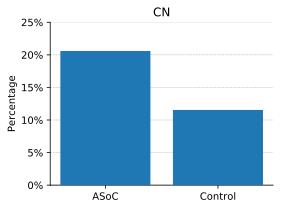

In [17]:
fig, ax = plt.subplots(figsize=(4,3))

ax.yaxis.grid(linestyle ='--', linewidth=0.5, zorder=0)
ax.bar([1,2],[countres[1]/countres[0], rcountres[1]/rcountres[0]], zorder=3)
plt.xticks([1,2], ['ASoC', 'Control'])
plt.yticks([0,0.05,0.1,0.15,0.2,0.25], ['0%','5%','10%','15%','20%','25%'])
plt.ylabel('Percentage')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('CN')
plt.show()
fig.savefig('CN_CMC_eQTL.pdf')

## 10kb distance -- FDR cutoff = 0.05

In [18]:
! awk -F' ' '$7 <0.05 {print $0}' CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt > CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt_fdr0.05

In [19]:
dista = 1e4
snpf = 'CN_20_ASoC_FDR0.05.bed.chrpos.hg19'
snprf = 'CN_20_ASoC_FDR0.05_matchedSNP/SNPmatch_100_matchedSNPs.txt'
annof = '/home/simingz/neuron_atac_seq/HiC/genecode.v29lift37.genes'
eQTLf = 'CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt_fdr0.05'

In [20]:
snp = []
with open(snpf, 'r') as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        snp.append('chr' + row[0])
print("Counting for ASoC sets")
countres = count_eqtl(snp,eQTLf,annof,dista)

Counting for ASoC sets
Number of SNPs: 5610
Number of SNPs within 10000bp of genes: 4554
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:853


In [21]:
snpr = []
with open(snprf, 'r') as f:
    csv_reader = csv.reader(f, delimiter="\t")
    next(csv_reader)
    for row in csv_reader:
        snpr.extend(['chr' + i for i in row[2:102]])
print("Counting for random SNP sets")
rcountres = count_eqtl(snpr,eQTLf,annof,dista)

Counting for random SNP sets
Number of SNPs: 508000
Number of SNPs within 10000bp of genes: 324246
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:33157


In [22]:
print('Percent of SNP is eQTL in ASoC: ' + str(countres[1]/countres[0]))
print('Percent of SNP is eQTL in matched random set: ' + str(rcountres[1]/rcountres[0]))

mystat = [[countres[1], countres[0] - countres[1]], [rcountres[1], rcountres[0] - rcountres[1]]]
odds, pvalue = stats.fisher_exact(mystat)
print('odds ratio: ' + str(odds) + "\np value: "+ str(pvalue))

Percent of SNP is eQTL in ASoC: 0.1873078612209047
Percent of SNP is eQTL in matched random set: 0.1022587788284204
odds ratio: 2.023394247327346
p value: 2.859791825374072e-65


# cell type NSC

## 10kb distance -- FDR cutoff = 0.1

In [23]:
dista = 1e4
snpf = 'NSC_20_ASoC_FDR0.05.bed.chrpos.hg19'
snprf = 'NSC_20_ASoC_FDR0.05_matchedSNP/SNPmatch_100_matchedSNPs.txt'
annof = '/home/simingz/neuron_atac_seq/HiC/genecode.v29lift37.genes'
eQTLf = 'CMC_MSSM-Penn-Pitt_DLPFC_mRNA_eQTL-adjustedSVA.txt_fdr0.1'

In [24]:
snp = []
with open(snpf, 'r') as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        snp.append('chr' + row[0])
print("Counting for ASoC sets")
countres = count_eqtl(snp,eQTLf,annof,dista)

Counting for ASoC sets
Number of SNPs: 3545
Number of SNPs within 10000bp of genes: 2785
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:526


In [25]:
snpr = []
with open(snprf, 'r') as f:
    csv_reader = csv.reader(f, delimiter="\t")
    next(csv_reader)
    for row in csv_reader:
        snpr.extend(['chr' + i for i in row[2:102]])
print("Counting for random SNP sets")
rcountres = count_eqtl(snpr,eQTLf,annof,dista)

Counting for random SNP sets
Number of SNPs: 321600
Number of SNPs within 10000bp of genes: 205264
Number of SNPs within 10000bp of genes that are also eQTLs of any of these genes:23120


In [26]:
print('Percent of SNP is eQTL in ASoC: ' + str(countres[1]/countres[0]))
print('Percent of SNP is eQTL in matched random set: ' + str(rcountres[1]/rcountres[0]))

mystat = [[countres[1], countres[0] - countres[1]], [rcountres[1], rcountres[0] - rcountres[1]]]
odds, pvalue = stats.fisher_exact(mystat)
print('odds ratio: ' + str(odds) + "\np value: "+ str(pvalue))

Percent of SNP is eQTL in ASoC: 0.1888689407540395
Percent of SNP is eQTL in matched random set: 0.11263543534180373
odds ratio: 1.8344106082398588
p value: 1.8969038549649642e-31


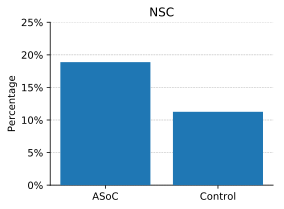

In [27]:
fig, ax = plt.subplots(figsize=(4,3))

ax.yaxis.grid(linestyle ='--', linewidth=0.5, zorder=0)
ax.bar([1,2],[countres[1]/countres[0], rcountres[1]/rcountres[0]], zorder=3)
plt.xticks([1,2], ['ASoC', 'Control'])
plt.yticks([0,0.05,0.1,0.15,0.2,0.25], ['0%','5%','10%','15%','20%','25%'])
plt.ylabel('Percentage')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('NSC')
plt.show()
fig.savefig('NSC_CMC_eQTL.pdf')

## Combined figure
plotted mannually